**Imports and Setup**

In [12]:
pf_id = 2
nfe = 6500
n_scenarios = 1000

In [13]:
import pickle

output_dict = {}
for Case in range(0,3):
    for experiment_number in range(1,3):
        try:
            with open(f'../final assignment/output/directed_search/Directed_Search_{Case}_{experiment_number}.kwakkel', 'rb') as filehandler:
                output_dict[(Case, experiment_number)] = pickle.load(filehandler)
                filehandler.close()
        except:
            print(f"No presaved output found for experiment_number {experiment_number} in Case {Case}")
#output_dict.keys()

No presaved output found for experiment_number 2 in Case 2


**nfe vs epsilon_progress in each scenario Case**

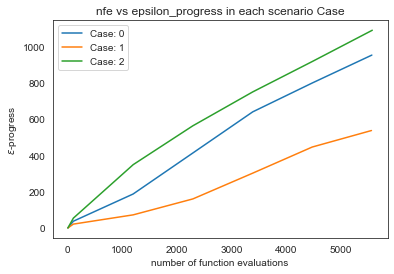

<Figure size 1080x1080 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
Case = 0
experiment_number = 1

fig, ax1 = plt.subplots()
#ax1.plot(convergence.nfe, convergence.epsilon_progress)

for Case in range(0,3):
    convergence = output_dict[(Case, experiment_number)][1]
    ax1.plot(convergence.nfe, convergence.epsilon_progress, label =f'Case: {Case}')

ax1.set_ylabel('$\epsilon$-progress')
ax1.set_xlabel('number of function evaluations')

ax1.legend()
ax1.set_title("nfe vs epsilon_progress in each scenario Case")

plt.figure(figsize=(15,15))

fig.savefig(f".\output\directed_search\Directed_Search_combined_{experiment_number}_epsilon_progress.svg", dpi=600)
fig.savefig(f".\output\directed_search\Directed_Search_combined_{experiment_number}_epsilon_progress.png", dpi=600)
plt.show()

**experiment 1 paracord plots**

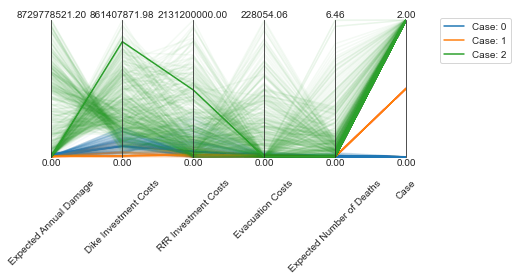

In [15]:
from ema_workbench.analysis import parcoords
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Case = 0
experiment_number = 1

colors = sns.color_palette()

merged_outcomes = None
for Case in range(0,3):
    output_dict[(Case, experiment_number)][0]["Case"] = int(Case)
    if merged_outcomes is None:
        merged_outcomes = pd.DataFrame(output_dict[(Case, experiment_number)][0])
    else:
        merged_outcomes = pd.concat([merged_outcomes, pd.DataFrame(output_dict[(Case, experiment_number)][0])])

outcomes = merged_outcomes.loc[:,['Expected Annual Damage','Dike Investment Costs','RfR Investment Costs','Evacuation Costs','Expected Number of Deaths','Case']]

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits, fontsize=10, rot=45)

# axes.plot(outcomes, label =f'Case: {Case}')
cases = []
for i, (index, row) in enumerate(outcomes.iterrows()):
    if row['Case'] in cases:
        axes.plot(row.to_frame().T, color=colors[int(row['Case'])], alpha=0.05)
    else:
        cases.append(row['Case'])
        axes.plot(row.to_frame().T, label=f"Case: {int(row['Case'])}", color=colors[int(row['Case'])])

axes.legend()

plt.savefig(f".\output\directed_search\Directed_Search_combined_{experiment_number}_paracord_scores.svg", dpi=600)
plt.savefig(f".\output\directed_search\Directed_Search_combined_{experiment_number}_paracord_scores.png", dpi=600)
plt.show()

**Load files**

In [16]:
experiment_number = 2

experiments = None
outcomes = None
for Case in range(0,3):
    try:
        output_dict[(Case, experiment_number)][0]["Case"] = int(Case)
        output_dict[(Case, experiment_number)][1]["Case"] = int(Case)
        if experiments is None:
            experiments = pd.DataFrame(output_dict[(Case, experiment_number)][0])
        else:
            experiments = pd.concat([experiments, pd.DataFrame(output_dict[(Case, experiment_number)][0])])
    except KeyError as e:
        print(f"No presaved experiments output found for experiment_number {experiment_number} in Case {Case}")
    try:
        if outcomes is None:
            outcomes = pd.DataFrame(output_dict[(Case, experiment_number)][1])
        else:
            outcomes = pd.concat([outcomes, pd.DataFrame(output_dict[(Case, experiment_number)][1])])
    except KeyError as e:
        print(f"No presaved outcomes output found for experiment_number {experiment_number} in Case {Case}")
outcomes = pd.DataFrame(outcomes).reset_index().drop(columns="index")
experiments = pd.DataFrame(experiments).reset_index().drop(columns="index")

experiments['scenario'] = experiments.index

No presaved experiments output found for experiment_number 2 in Case 2
No presaved outcomes output found for experiment_number 2 in Case 2


In [17]:
exp_group = experiments.groupby(by = 'policy')
experiments = None
for name, group in exp_group:
    group.reset_index(inplace = True)
    group['scenario'] = group.index
    group.index = group['index']
    group = group.drop(columns = 'index')
    #exp_group.groups[name] = group
    if experiments is None:
        experiments = group
    else:
        experiments = pd.concat([experiments, group])

experiments.sort_values(['Case','policy','scenario'], inplace=True)

In [18]:
from ema_workbench import (ScalarOutcome, Scenario, MultiprocessingEvaluator, SequentialEvaluator)
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.util import ema_logging
import pandas as pd
import numpy as np
import seaborn as sns

ema_logging.log_to_stderr(ema_logging.INFO)

model, planning_steps = get_model_for_problem_formulation(pf_id)

def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)

    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy

    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T

def calculate_regret(data, best):
    return np.abs(best-data)

overall_regret = {}
max_regret = {}
regret_by_case = {}
overall_by_case = {}

exp_group = experiments.groupby(by = 'Case')
out_group = outcomes.groupby(by = 'Case')

exp_group = dict(tuple(exp_group))
out_group = dict(tuple(out_group))

for outcome in model.outcomes:
    for Case in experiments['Case'].unique():
        policy_column = exp_group[Case]['policy']

        # create a DataFrame with all the relevent information
        # i.e., policy, scenario_id, and scores
        data = pd.DataFrame({outcome.name: out_group[Case][outcome.name],
                             "Case":exp_group[Case]['Case'],
                             "policy":exp_group[Case]['policy'],
                             "scenario":exp_group[Case]['scenario']})

        # reorient the data by indexing with policy and scenario id
        data = data.pivot(index='scenario', columns='policy')

        # flatten the resulting hierarchical index resulting from
        # pivoting, (might be a nicer solution possible)
        data.columns = data.columns.get_level_values(1)

        # we need to control the broadcasting.
        # max returns a 1d vector across scenario id. By passing
        # np.newaxis we ensure that the shape is the same as the data
        # next we take the absolute value
        #
        # basically we take the difference of the maximum across
        # the row and the actual values in the row
        #
        outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()

        overall_regret[outcome.name] = outcome_regret

        # overall_by_case[Case] = {}
        # overall_by_case[Case][outcome.name] = outcome_regret
        # overall_by_case[Case]['Case'] = pd.Series([Case]).repeat(len(outcome_regret))
        # overall_by_case[Case]['Case'].reset_index(drop=True, inplace=True)

        regret_by_case[Case] = {}
        regret_by_case[Case][outcome.name] = outcome_regret.max()
        regret_by_case[Case]['Case'] = pd.Series([Case]).repeat(len(outcome_regret.max()))
        regret_by_case[Case]['Case'].reset_index(drop=True, inplace=True)

    for Case in regret_by_case:
        if outcome.name in max_regret:
            max_regret['Case'] = pd.concat([max_regret['Case'], regret_by_case[Case]['Case']])
            max_regret[outcome.name] = pd.concat([max_regret[outcome.name], regret_by_case[Case][outcome.name]])
        else:
            max_regret['Case'] = regret_by_case[Case]['Case']
            max_regret[outcome.name] = regret_by_case[Case][outcome.name]
        # if outcome.name in overall_regret:
        #     overall_regret['Case'] = pd.concat([overall_regret['Case'], overall_by_case[Case]['Case']])
        #     overall_regret[outcome.name] = overall_regret[outcome.name] + overall_by_case[Case][outcome.name]
        # else:
        #     overall_regret['Case'] = overall_by_case[Case]['Case']
        #     overall_regret[outcome.name] = overall_by_case[Case][outcome.name]
#max_regret['index'] = pd.Series(range(0,len(max_regret['Case'])))
for item in max_regret.keys():
    max_regret[item].reset_index(drop=True, inplace=True)
# for item in overall_regret.keys():
#     overall_regret[item].reset_index(drop=True, inplace=True)

C:\Users\rhys_\AppData\Local\Temp\ipykernel_11244\1430030177.py:75: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\rhys_\AppData\Local\Temp\ipykernel_11244\1430030177.py:75: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\rhys_\AppData\Local\Temp\ipykernel_11244\1430030177.py:75: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\rhys_\AppData\Local\Temp\ipykernel_11244\14

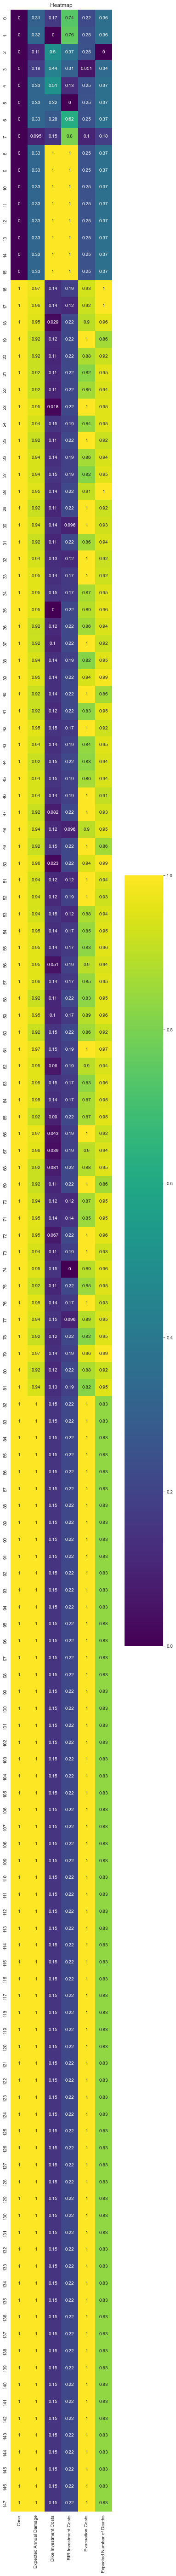

In [19]:
max_regret = pd.DataFrame.from_dict(max_regret)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,100),
                         sharey=True, sharex=True)
ax.set_title("Heatmap")
sns.heatmap(max_regret/max_regret.max(),annot_kws={'size': 10}, cmap='viridis', square=True, annot=True, ax=ax)

plt.savefig(f".\output\directed_search\Directed_Search_combined_{experiment_number}_heatmap.svg", dpi=600)
plt.savefig(f".\output\directed_search\Directed_Search_combined_{experiment_number}_heatmap.png", dpi=600)

plt.show()

In [ ]:
data = max_regret

colors = sns.color_palette()


# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
#limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

plt.figure(figsize=(15,15))
paraxes = parcoords.ParallelAxes(limits, fontsize=10, rot=45)
cases = []
for i, (index, row) in enumerate(data.iterrows()):
    if row['Case'] in cases:
        paraxes.plot(row.to_frame().T, color=colors[int(row['Case'])], alpha=0.1)
    else:
        cases.append(row['Case'])
        paraxes.plot(row.to_frame().T, label=f"Case: {int(row['Case'])}", color=colors[int(row['Case'])], alpha=0.05)

paraxes.legend()

plt.savefig(f".\output\directed_search\Directed_Search_combined_{experiment_number}_paracord_regret.svg", dpi=600)
plt.savefig(f".\output\directed_search\Directed_Search_combined_{experiment_number}_paracord_regret.png", dpi=600)

plt.show()

In [21]:
from collections import defaultdict

max_regret2 = {}
overall_regret2 = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']

    data = pd.DataFrame({outcome.name: outcomes[outcome.name],
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    data = data.pivot(index='scenario', columns='policy')
    data.columns = data.columns.get_level_values(1)
    outcome_regret2 = (data.max(axis=1)[:, np.newaxis] - data).abs()
    overall_regret2[outcome.name] = outcome_regret2
    max_regret2[outcome.name] = outcome_regret2.max()

max_regret2 = pd.DataFrame(max_regret2)

policy_regret = defaultdict(dict)
for key, value in overall_regret2.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

C:\Users\rhys_\AppData\Local\Temp\ipykernel_11244\58630514.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret2 = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\rhys_\AppData\Local\Temp\ipykernel_11244\58630514.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret2 = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\rhys_\AppData\Local\Temp\ipykernel_11244\58630514.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret2 = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\rhys_\AppData\Local\Temp\ipykernel_11244\58630

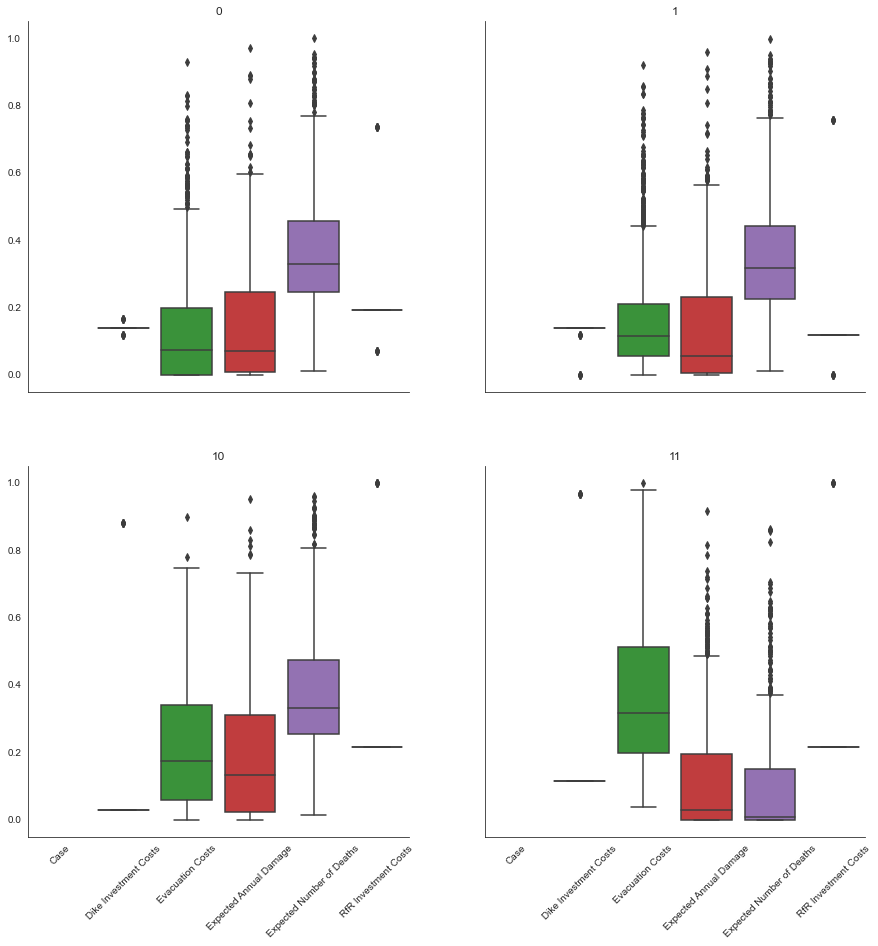

In [22]:
# this generates a 2 by 2 axes grid, with a shared X and Y axis
# accross all plots
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15,15),
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this.
axes = [axes[0,0], axes[0,1],
        axes[1,0], axes[1,1]]

# zip allows us to zip together the list of axes and the list of
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)

    # removes top and left hand black outline of axes
    sns.despine()

    # ensure we know which policy the figure is for
    ax.set_title(str(policy))

    ax.tick_params(axis='x', rotation=45)

# plt.tight_layout()

plt.savefig(f".\output\directed_search\Directed_Search_combined_{experiment_number}_box_and_whiskers.svg", dpi=600)
plt.savefig(f".\output\directed_search\Directed_Search_combined_{experiment_number}_box_and_whiskers.png", dpi=600)

plt.show()

**Needs to be Fixed**

the choice for box 42 is somewhat arbitrary.